In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

2019                                                              \
         count      mean       std       min       25%       50%       75%   
type                                                                         
ПП    480143.0  0.050525  0.034566 -0.363985  0.024732  0.036040  0.071505   
ТТ    222044.0  0.022281  0.026995 -0.214685  0.003175  0.018021  0.028950   

                    2020            ...                          2021  \
           max     count      mean  ...       75%       max     count   
type                                ...                                 
ПП    0.212312  480143.0  0.030870  ...  0.048857  0.120363  480143.0   
ТТ    0.227761  222044.0  0.010802  ...  0.021959  0.128853  222044.0   

                                                                            
          mean       std       min       25%       50%       75%       max  
type                                                                        
ПП    0.049555  0.046380 -0.187553  0.012630  0.028860  0.089940  0.279701  
ТТ    0.032052  0.034072 -0.126533  0.007222  0.015969  0.061475  0.193939  

[2 rows x 24 columns]

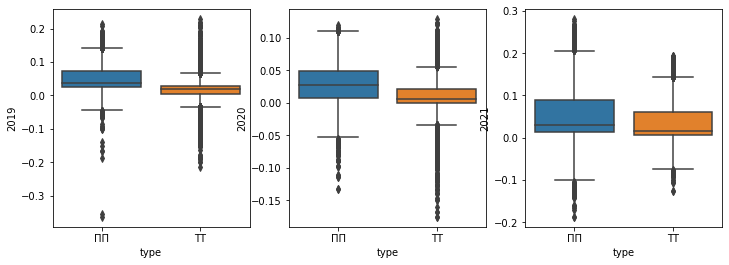

In [3]:
archangelskoe = gpd.read_file('vector_data/archangelskoe.geojson')
dobrovolnoe = gpd.read_file('vector_data/dobrovolnoe.geojson')
agriculture = gpd.read_file('vector_data/agriculture.geojson')

with rasterio.open("raster_data/minNDTI_3_years.tif", 'r') as main_raster:
    archan, out_transform = mask(main_raster, archangelskoe.geometry, crop=True, nodata= np.nan)
    dobrovol, out_transform = mask(main_raster, dobrovolnoe.geometry, crop=True, nodata= np.nan)
    out_meta = main_raster.meta

No_till_raster_data = archan.reshape(3,-1).T
traditional_raster_data = dobrovol.reshape(3,-1).T

No_till_raster_data[No_till_raster_data == -10] = np.nan
No_till_raster_data[No_till_raster_data == 0] = np.nan
No_till_raster_data = No_till_raster_data[~np.isnan(No_till_raster_data).any(axis=1)]
No_till_df = pd.DataFrame(No_till_raster_data, columns=['2019','2020','2021'])
No_till_df['type'] = "ПП"



traditional_raster_data[traditional_raster_data == -10] = np.nan
traditional_raster_data[traditional_raster_data == 0] = np.nan
traditional_raster_data = traditional_raster_data[~np.isnan(traditional_raster_data).any(axis=1)]
traditional_df = pd.DataFrame(traditional_raster_data, columns=['2019','2020','2021'])
traditional_df['type'] = "ТТ"



general_df = No_till_df.append(traditional_df)

sample = general_df

fig, axes = plt.subplots(1,3, figsize=(12,4)) 

sns.boxplot(data = sample , x = 'type', y = '2019', ax = axes[0])
sns.boxplot(data = sample , x = 'type', y = '2020', ax = axes[1])
sns.boxplot(data = sample , x = 'type', y = '2021', ax = axes[2])



sample.groupby(['type']).describe()

прискорбно, но необходимо чистить данные вручную 


In [4]:
def cut_by_15IQR(data):
    first = np.array(data.describe().iloc[4]) # первый квартиль
    third  = np.array(data.describe().iloc[6]) # третий квартиль

    IQL1_5 = 1.5 *(third - first) # 1.5 межквартильного размаха
    top = third + IQL1_5
    bottom = first - IQL1_5
    df = data.copy()
    for i in range(IQL1_5.shape[0]):
        df = df[( df.iloc[:,i] <= top[i]) & ( df.iloc[:,i] >= bottom[i]) ]
    return(df)

No_till_df_cuted = cut_by_15IQR(No_till_df)
traditional_df_cuted = cut_by_15IQR(traditional_df)


general_df = No_till_df_cuted.append(traditional_df_cuted)


sample = general_df.sample(5000)

2019                                                              \
       count      mean       std       min       25%       50%       75%   
type                                                                       
ПП    3541.0  0.048877  0.032943 -0.038134  0.024469  0.034758  0.069472   
ТТ    1459.0  0.014380  0.015252 -0.030451  0.002337  0.013559  0.024705   

                  2020            ...                        2021            \
           max   count      mean  ...       75%       max   count      mean   
type                              ...                                         
ПП    0.141622  3541.0  0.030453  ...  0.048639  0.109322  3541.0  0.047746   
ТТ    0.067595  1459.0  0.011462  ...  0.022689  0.054430  1459.0  0.030985   

                                                                  
           std       min       25%       50%       75%       max  
type                                                              
ПП    0.045654 -0.072121  0.012142  0.027706  0.088205  0.203816  
ТТ    0.033563 -0.057230  0.005711  0.014871  0.061719  0.142315  

[2 rows x 24 columns]

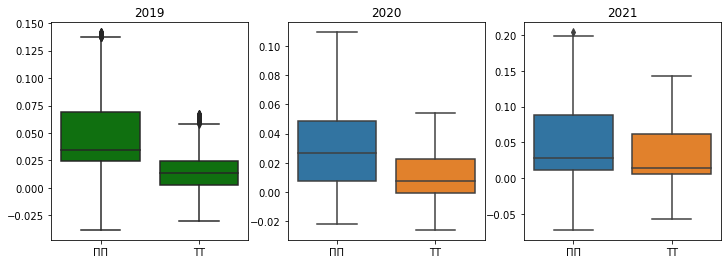

In [10]:


fig, axes = plt.subplots(1,3, figsize=(12,4)) 


my_pal = {"ПП": "#38FF02", "ТТ": "#FF0202"}


sns.boxplot(data = sample , x = 'type', y = '2019',palette = my_pal, ax = axes[0])
axes[0].set(title = '2019', xlabel = '',ylabel = '' )


sns.boxplot(data = sample , x = 'type', y = '2020',palette = my_pal, ax = axes[1])
axes[1].set(title = '2020', xlabel = '',ylabel = '' )


sns.boxplot(data = sample , x = 'type', y = '2021',palette = my_pal, ax = axes[2])
axes[2].set(title = '2021', xlabel = '',ylabel = '' )



sample.groupby(['type']).describe()

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

X = sample[['2019','2020','2021']].values
y = sample['type'].values.reshape(-1,1)

y = y.astype(int)

x_train, x_test, y_train, y_test = train_test_split(X , y,test_size = 0.2, random_state=13)

In [22]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(x_train, y_train)
predictions = clf.predict(x_test)
print(classification_report(y_test, predictions))
cross_val_score(clf, x_test, y_test, cv=10).mean()

              precision    recall  f1-score   support

           0       0.91      0.07      0.12       298
           1       0.72      1.00      0.83       702

    accuracy                           0.72      1000
   macro avg       0.81      0.53      0.48      1000
weighted avg       0.77      0.72      0.62      1000



0.702

In [23]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
neigh.fit(x_train, y_train)
predictions = neigh.predict(x_test)
print(classification_report(y_test, predictions))
cross_val_score(clf, x_train, y_train, cv=10).mean()

              precision    recall  f1-score   support

           0       0.89      0.86      0.88       298
           1       0.94      0.96      0.95       702

    accuracy                           0.93      1000
   macro avg       0.92      0.91      0.91      1000
weighted avg       0.93      0.93      0.93      1000



0.7162499999999999

In [24]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print(classification_report(y_test, predictions))
cross_val_score(clf, x_train, y_train, cv=10).mean()

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       298
           1       0.94      0.91      0.92       702

    accuracy                           0.90      1000
   macro avg       0.87      0.89      0.88      1000
weighted avg       0.90      0.90      0.90      1000



0.8942499999999999

In [25]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print(classification_report(y_test, predictions))
cross_val_score(clf, x_train, y_train, cv=10).mean()

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       298
           1       0.94      0.96      0.95       702

    accuracy                           0.93      1000
   macro avg       0.92      0.91      0.92      1000
weighted avg       0.93      0.93      0.93      1000



0.9285000000000002

In [26]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print(classification_report(y_test, predictions))
cross_val_score(clf, x_train, y_train, cv=10).mean()

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       298
           1       0.93      0.96      0.94       702

    accuracy                           0.92      1000
   macro avg       0.91      0.89      0.90      1000
weighted avg       0.92      0.92      0.92      1000



0.92125

# самый лучший рендом форест 

In [27]:
RFC = RandomForestClassifier(random_state=0)
RFC.fit(x_train, y_train)

def mapping(raster, vector):
    meta_data = raster.meta
    CRS = raster.crs
    meta_data['count'] = 1
    meta_data['dtype'] = 'float64'

    dir = 'raster_data/classified.tif'

    raster_shape = raster.shape
    data = raster.read().reshape(3,-1).T

    data = np.nan_to_num(data, copy=True, nan=0.0, posinf=None, neginf=None)

    proba_data = RFC.predict_proba(data)[:,1]
    proba_data = proba_data.reshape(raster_shape)
    new_dataset = rasterio.open(dir, 'w', **meta_data)
    new_dataset.write(proba_data, 1)
    new_dataset.close()

    vector_reproj = vector.to_crs(CRS)

    classified_data = rasterio.open(dir, 'r')


    masked_raster, affine__ = mask(classified_data ,vector_reproj.geometry, invert= False)
    new_dataset = rasterio.open(dir, 'w', **meta_data)
    new_dataset.write(masked_raster)
    new_dataset.close()


In [28]:
main_raster = rasterio.open("raster_data/minNDTI_3_years.tif", 'r') 
mapping(main_raster, agriculture )

In [29]:
# оставляем так, это уже повеселее выглядит